In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler


# PREPROCESAMIENTO DE LOS DATOS

Debido a la compejidad del dataset se tratará de forma individual cada variable.

In [2]:
data= pd.read_csv("Data/train.csv")
data = data.drop('Id', axis=1)

### SalePrice

In [3]:
data['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: >

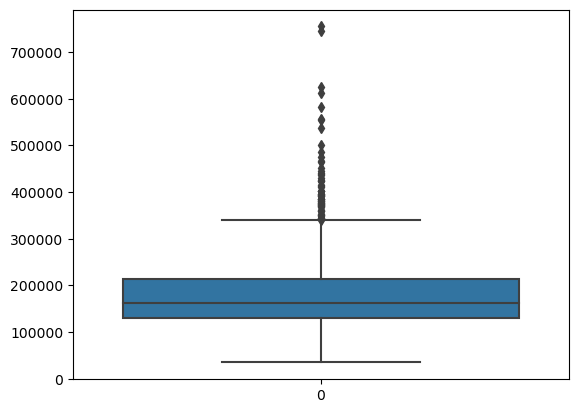

In [4]:
sns.boxplot(data['SalePrice'])


Se observan valores por encimade 700.000 dólares que encaja dentro de lo que puede llegar a valer una casa en Estados Unidos, por lo cual se conservan todos los valores.


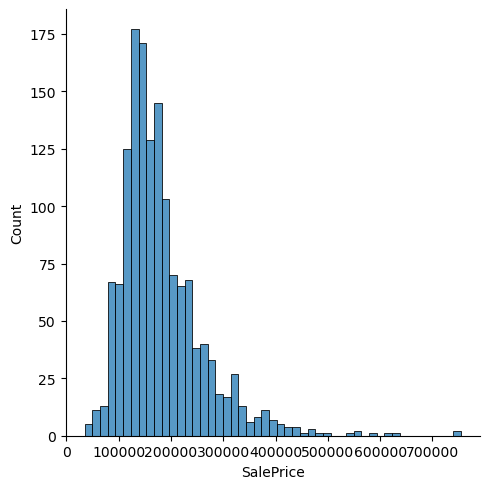

In [5]:
sns.displot(data['SalePrice'])

In [6]:
data['SalePrice'].skew()

1.8828757597682129

La variable presenta una asimetría de 1,88. Si bien algunos modelos se beneficián de una variable objetivo con distribución normal, los modelos no lineales como como árboles de decisión, random forests o boosting no la necesitan, así que no se le aplicará ningún tipo de transformación para corregir la distribución Sin embargo para las variables que se entrenan si que se aplicará transformación logarítmica si la asimetría es muy elevada para mejorar el rendimiento del modelo.


## MSSubClass

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

La variable MSSubClass es en realidad de tipo categórica, por lo que debe ser tratada como tal.


In [7]:
data.groupby("MSSubClass")["MSSubClass"].count()

MSSubClass
20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      58
85      20
90      52
120     87
160     63
180     10
190     30
Name: MSSubClass, dtype: int64

Sin embargo, el número de categorías es demasiado elevado, antes de hacer el encoding se agruparan teniendo en cuenta el número de pisos.

In [8]:
data['MSSubClass'] = data['MSSubClass'].replace({
    20: '1-STORY',
    30: '1-STORY',
    40: '1-STORY',
    120: '1-STORY',
    45: '1.5-STORY',
    50: '1.5-STORY',
    150: '1.5-STORY',
    60: '2-STORY',
    70: '2-STORY',
    160: '2-STORY',
    75: '2.5-STORY',
    80: 'SPLIT/MULTI-LEVEL',
    85: 'SPLIT/MULTI-LEVEL',
    180: 'SPLIT/MULTI-LEVEL',
    90: 'DUPLEX',
    190: '2 FAMILY CONVERSION'
})

cleaned_data = data.copy()
ms_subclass_encoded = pd.get_dummies(cleaned_data['MSSubClass'], prefix='MSSubClass', drop_first=True)
cleaned_data = cleaned_data.drop('MSSubClass', axis=1)
cleaned_data = pd.concat([cleaned_data, ms_subclass_encoded], axis=1)



## MSZoning

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [9]:
data.groupby("MSZoning")["MSZoning"].count()

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
Name: MSZoning, dtype: int64

In [10]:
data.groupby("MSZoning")["SalePrice"].mean()

MSZoning
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275
Name: SalePrice, dtype: float64

Si bien hay categorías infrarrepresentadas agruparlas en una sola no parece una buena idea pues tienen asociados precios de venta muy dispares.

In [11]:
mszoning_encoded = pd.get_dummies(cleaned_data['MSZoning'], prefix='MSZoning', drop_first=True)
cleaned_data = pd.concat([cleaned_data, mszoning_encoded], axis=1)
cleaned_data = cleaned_data.drop('MSZoning', axis=1)


## LotFrontage

LotFrontage: Linear feet of street connected to property

In [12]:
data["LotFrontage"].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

<Axes: >

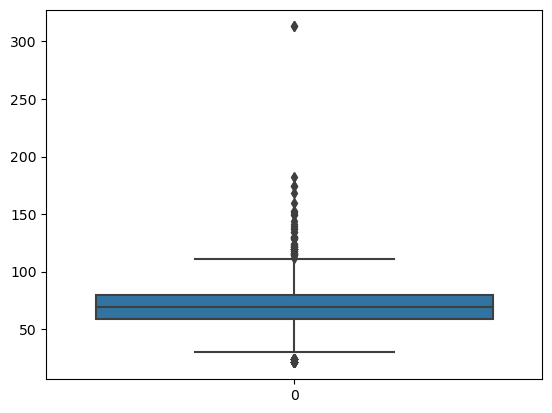

In [13]:
sns.boxplot(data['LotFrontage'])


In [14]:
cleaned_data = cleaned_data.drop(cleaned_data[cleaned_data['LotFrontage'] == 313].index)


El máximo de LotFrontage es 300 pies que equivalen a unos 90 metros, parece inverosimil que propiedad residencial tenga esta medida, además de acuerdo a su correspondiente valor de LotArea la propiedad tendría una forma extremadamente alargada, con lo cual se asume que es un error de recogida de datos y se elimina.

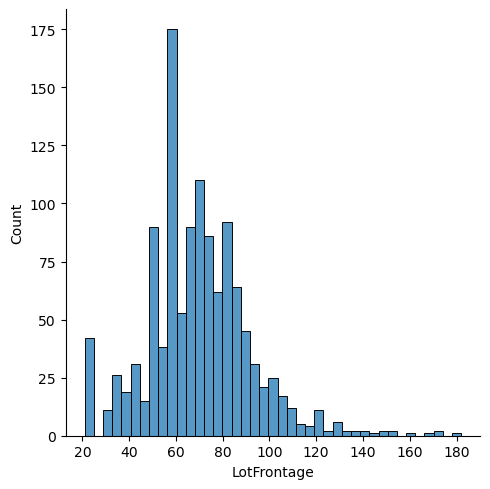

In [15]:
sns.displot(cleaned_data['LotFrontage'])


Hay 259 valores nulos, teniendo en cuenta que en el dataset no hay valores menores de 20 pies, no sería descabellado pensar que los NaN se correspondan en realidad a valores de 0 o cercanos a 0, apoya esta teoría la mayor proporción de terrenos de forma irregular entre las filas que tienen valores de LotFrontage NaN. Por lo tanto se sustituyen los NaN por 0.

In [16]:
lotshape_total_counts = data['LotShape'].value_counts(normalize=True) * 100

print("Porcentaje total de categorías en LotShape:")
print(lotshape_total_counts)

Porcentaje total de categorías en LotShape:
Reg    63.356164
IR1    33.150685
IR2     2.808219
IR3     0.684932
Name: LotShape, dtype: float64


In [17]:
nan_lotfrontage = data[data['LotFrontage'].isna()]
lotshape_counts = nan_lotfrontage['LotShape'].value_counts(normalize=True) * 100


print("Porcentaje de categorías en LotShape con LotFrontage NaN:")
print(lotshape_counts)



Porcentaje de categorías en LotShape con LotFrontage NaN:
IR1    64.478764
Reg    28.571429
IR2     5.791506
IR3     1.158301
Name: LotShape, dtype: float64


In [18]:
cleaned_data['LotFrontage'].fillna(0, inplace=True)


## LotArea


Lot size in square feet

In [19]:
data["LotArea"].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

<Axes: >

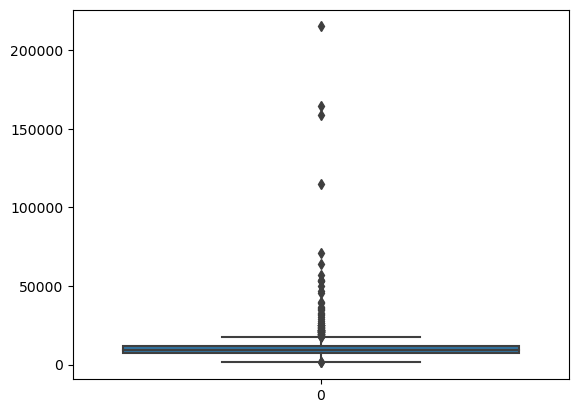

In [20]:
sns.boxplot(data['LotArea'])


Hay varias propiedades con un valor de LotArea muy alto; sin embargo, todas las propiedades con un valor superior a 50,000 pies cuadrados pertenecen a zonas residenciales de baja densidad, lo que tiene cierto sentido. Eso sí, se les aplica a los datos una transformación logarítmica para corregir el fuerte sesgo a la derecha que tienen.

In [21]:
houses_above_50000 = data[data['LotArea'] > 50000]
mszoning_counts = houses_above_50000['MSZoning'].value_counts()

print("Número de casas mayores de 50,000 pies cuadrados por categoría de MSZoning:")
print(mszoning_counts)

Número de casas mayores de 50,000 pies cuadrados por categoría de MSZoning:
RL    11
Name: MSZoning, dtype: int64


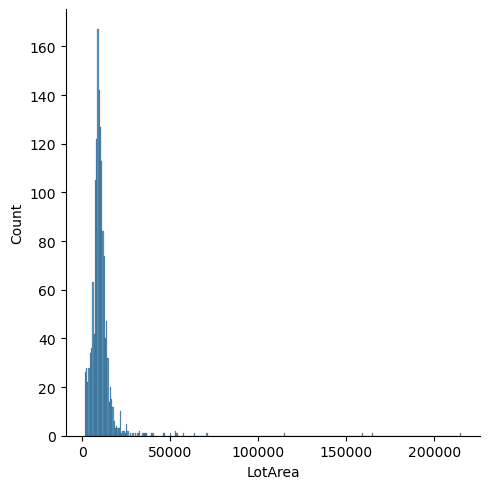

In [22]:
sns.displot(data['LotArea'])


In [23]:
data["LotArea"].skew()

12.207687851233496

In [24]:
cleaned_data['LotArea'] = np.log1p(cleaned_data['LotArea'])

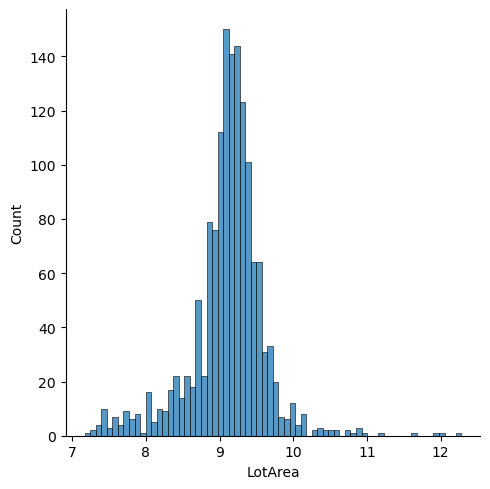

In [25]:
sns.displot(cleaned_data['LotArea'])


## Street


Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved

In [26]:
data.groupby("Street")["Street"].count()

Street
Grvl       6
Pave    1454
Name: Street, dtype: int64

In [27]:
data.groupby("Street")["SalePrice"].mean()

Street
Grvl    130190.500000
Pave    181130.538514
Name: SalePrice, dtype: float64

El valor predictivo de esta variable es nulo, ya que la práctica totalidad de las muestras pertencen a la categoría Pave y tampoco es que se observen grandes diferencias de precio.

In [28]:
cleaned_data = cleaned_data.drop('Street', axis=1)

## Alley

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [29]:
data.groupby("Alley")["Alley"].count()

Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64

Tal como se explica en la documentación facilitada, los valores nulos corresponden a propiedades sin callejón de acceso. Se puede, por tanto, crear una tercera categoría con esos valores. Sin embargo, las categorías están muy desbalanceadas y no parece haber una relación muy evidente con el precio. Es posible que, aún así, se relacione de forma no lineal con este último. Pero los beneficios de mantenerla se antojan insuficientes frente al aumento de dimensionalidad que supondría el one-hot encoding correspondiente.

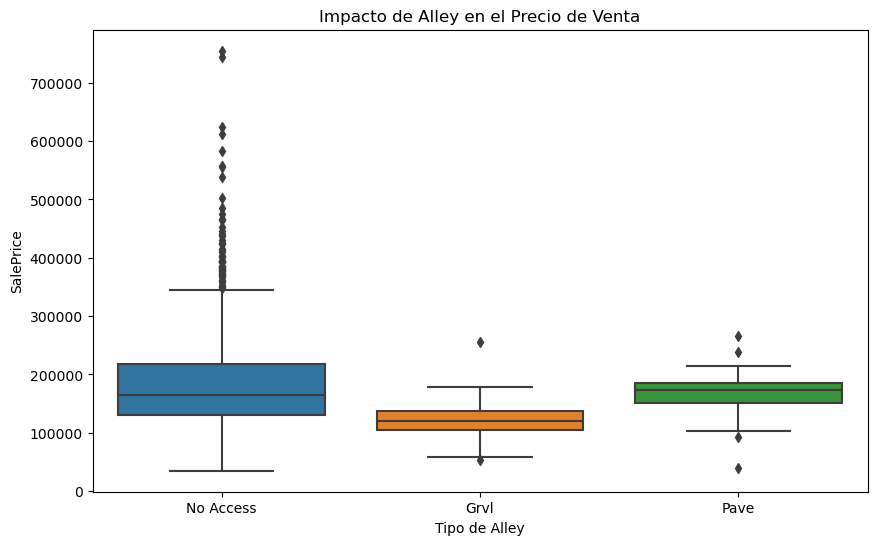

In [30]:
cleaned_data['Alley'] = cleaned_data['Alley'].fillna('No Access')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Alley', y='SalePrice', data=cleaned_data)
plt.title('Impacto de Alley en el Precio de Venta')
plt.xlabel('Tipo de Alley')
plt.ylabel('SalePrice')
plt.show()

In [31]:
cleaned_data = cleaned_data.drop('Alley', axis=1)

## LotShape

LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       

In [32]:
data.groupby("LotShape")["LotShape"].count()

LotShape
IR1    484
IR2     41
IR3     10
Reg    925
Name: LotShape, dtype: int64

Una buena forma de reducir la dimensionalidad es agrupar las tres categorías de forma irregular en una sola.

In [33]:
cleaned_data['LotShape'] = cleaned_data['LotShape'].replace({'IR1': 'IR', 'IR2': 'IR', 'IR3': 'IR'})
lotshape_encoded = pd.get_dummies(cleaned_data['LotShape'], prefix='LotShape', drop_first=True)
cleaned_data = cleaned_data.drop('LotShape', axis=1)
cleaned_data = pd.concat([cleaned_data, lotshape_encoded], axis=1)

 ## LandContour


LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

In [34]:
data.groupby("LandContour")["LandContour"].count()

LandContour
Bnk      63
HLS      50
Low      36
Lvl    1311
Name: LandContour, dtype: int64

De forma similar a la variable anterior también se reagrupan las categorías.

In [35]:
cleaned_data['LandContour'] = cleaned_data['LandContour'].replace({'Lvl': 'Lvl', 'Bnk': 'No Lvl', 'HLS': 'No Lvl', 'Low': 'No Lvl'})
landcontour_encoded = pd.get_dummies(cleaned_data['LandContour'], prefix='LandContour', drop_first=True)
cleaned_data = cleaned_data.drop('LandContour', axis=1)
cleaned_data = pd.concat([cleaned_data, landcontour_encoded], axis=1)

## Utilities

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	

In [36]:
data.groupby("Utilities")["Utilities"].count()

Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Esta variable carece de valor predictivo.

In [37]:
cleaned_data = cleaned_data.drop('Utilities', axis=1)

## LotConfig

LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

In [38]:
data.groupby("LotConfig")["LotConfig"].count()

LotConfig
Corner      263
CulDSac      94
FR2          47
FR3           4
Inside     1052
Name: LotConfig, dtype: int64

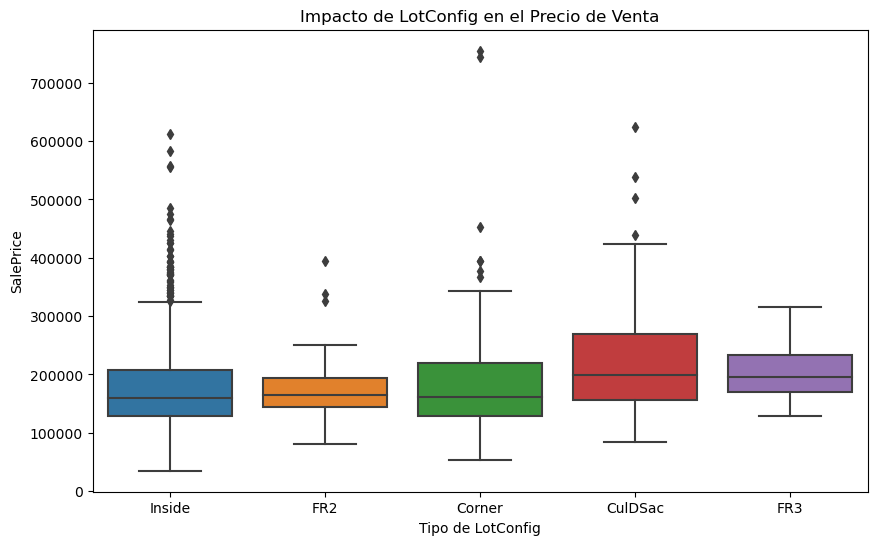

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LotConfig', y='SalePrice', data=cleaned_data)
plt.title('Impacto de LotConfig en el Precio de Venta')
plt.xlabel('Tipo de LotConfig')
plt.ylabel('SalePrice')
plt.show()

En este caso se mantienen todas las categorías al no tener una forma clara de agruparlas y al haber cierta influencia en el precio.

In [40]:
lotconfig_encoded = pd.get_dummies(cleaned_data['LotConfig'], prefix='LotConfig', drop_first=True)
cleaned_data = cleaned_data.drop('LotConfig', axis=1)
cleaned_data = pd.concat([cleaned_data, lotconfig_encoded], axis=1)


## LandsLope

LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

In [41]:
data.groupby("LandSlope")["LandSlope"].count()

LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

En este caso se reagrupan las dos columnas en las que hay algo de inclinación 

In [42]:
cleaned_data['LandSlope'] = cleaned_data['LandSlope'].replace({'Gtl': 'Gtl', 'Mod': 'No Gtl', 'Sev': 'No Gtl'})
landslope_encoded = pd.get_dummies(cleaned_data['LandSlope'], prefix='LandSlope', drop_first=True)
cleaned_data = cleaned_data.drop('LandSlope', axis=1)
cleaned_data = pd.concat([cleaned_data, landslope_encoded], axis=1)


## Neighborhood

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

Esta variable tiene demasiadas categorías, al ser imposible codificarlas de forma ordinal, un onehot encoding aumentaría demasiado la dimesionalidad. La solución es reagrupar los barrios en tres categorías según su precio medio.

In [43]:
neighborhood_price = cleaned_data.groupby('Neighborhood')['SalePrice'].mean()
neighborhood_price 

Neighborhood
Blmngtn    194870.882353
Blueste    137500.000000
BrDale     104493.750000
BrkSide    124834.051724
ClearCr    212565.428571
CollgCr    197965.773333
Crawfor    210624.725490
Edwards    127898.686869
Gilbert    192854.506329
IDOTRR     100123.783784
MeadowV     98576.470588
Mitchel    156270.122449
NAmes      145417.825893
NPkVill    142694.444444
NWAmes     189050.068493
NoRidge    335295.317073
NridgHt    316270.623377
OldTown    128225.300885
SWISU      142591.360000
Sawyer     136793.135135
SawyerW    186555.796610
Somerst    225379.837209
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Name: SalePrice, dtype: float64

In [44]:
neighborhood_dict = {}
for neighborhood, price in neighborhood_price.items():
    if price < 129975:
        neighborhood_dict[neighborhood] = 'LowPrice'
    elif price < 214000:
        neighborhood_dict[neighborhood] = 'MildPrice'
    else:
        neighborhood_dict[neighborhood] = 'HighPrice'


In [45]:
neighborhood_dict

{'Blmngtn': 'MildPrice',
 'Blueste': 'MildPrice',
 'BrDale': 'LowPrice',
 'BrkSide': 'LowPrice',
 'ClearCr': 'MildPrice',
 'CollgCr': 'MildPrice',
 'Crawfor': 'MildPrice',
 'Edwards': 'LowPrice',
 'Gilbert': 'MildPrice',
 'IDOTRR': 'LowPrice',
 'MeadowV': 'LowPrice',
 'Mitchel': 'MildPrice',
 'NAmes': 'MildPrice',
 'NPkVill': 'MildPrice',
 'NWAmes': 'MildPrice',
 'NoRidge': 'HighPrice',
 'NridgHt': 'HighPrice',
 'OldTown': 'LowPrice',
 'SWISU': 'MildPrice',
 'Sawyer': 'MildPrice',
 'SawyerW': 'MildPrice',
 'Somerst': 'HighPrice',
 'StoneBr': 'HighPrice',
 'Timber': 'HighPrice',
 'Veenker': 'HighPrice'}

In [46]:
cleaned_data['Neighborhood'] = cleaned_data['Neighborhood'].map(neighborhood_dict)
cleaned_data.groupby('Neighborhood')['Neighborhood'].count()

Neighborhood
HighPrice    278
LowPrice     340
MildPrice    840
Name: Neighborhood, dtype: int64

Las nuevas categorías son susceptibles de codificarse de forma ordinal, lo que contribuye al objetivo de reducir la dimensionalidad.

In [47]:
price_order = {'HighPrice': 2, 'MildPrice': 1, 'LowPrice': 0}
cleaned_data['Neighborhood'] = cleaned_data['Neighborhood'].map(price_order)

## Condition 1 y 2

Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

Estas dos variables en realidad son la misma (hay dos columnas por si en una propiedad se cumple más de una condición). Lo primero que se hará será agrupar las categorías en función de su naturaleza. posteriormente se hará el onehot endoding a las dos columnas y luego se sumarán las correspondientes columnas resultantes, de tal forma que si una propiedad tiene Artery y Feedr la nueva columna Street tendrá un valor de 2. También se elimina Norm ya que en la práctica es un valor neutro equivalente a 0.

In [48]:
cleaned_data['Condition1'] = cleaned_data['Condition1'].replace({
    'Norm': 'Normal',
    'Artery': 'Street',
    'Feedr': 'Street',
    'RRNn': 'Railroad',
    'RRAn': 'Railroad',
    'PosN': 'Positive Feature',
    'PosA': 'Positive Feature',
    'RRNe': 'Railroad',
    'RRAe': 'Railroad'
})

cleaned_data['Condition2'] = cleaned_data['Condition2'].replace({
    'Norm': 'Normal',
    'Artery': 'Street',
    'Feedr': 'Street',
    'RRNn': 'Railroad',
    'RRAn': 'Railroad',
    'PosN': 'Positive Feature',
    'PosA': 'Positive Feature',
    'RRNe': 'Railroad',
    'RRAe': 'Railroad'
})

condition1_encoded = pd.get_dummies(cleaned_data['Condition1'], prefix='Condition1', drop_first=True)
condition2_encoded = pd.get_dummies(cleaned_data['Condition2'], prefix='Condition2', drop_first=True)

cleaned_data['Street_Condition'] = condition1_encoded.get('Condition1_Street', 0) + condition2_encoded.get('Condition2_Street', 0)
cleaned_data['Railroad_Condition'] = condition1_encoded.get('Condition1_Railroad', 0) + condition2_encoded.get('Condition2_Railroad', 0)
cleaned_data['PositiveFeature_Condition'] = condition1_encoded.get('Condition1_Positive Feature', 0) + condition2_encoded.get('Condition2_Positive Feature', 0)

cleaned_data = cleaned_data.drop(columns=['Condition1'])
cleaned_data = cleaned_data.drop(columns=['Condition2'])






## BldgType

BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

In [49]:
data.groupby("BldgType")["BldgType"].count()

BldgType
1Fam      1220
2fmCon      31
Duplex      52
Twnhs       43
TwnhsE     114
Name: BldgType, dtype: int64

Para agupar esta variable se usa el criterio si la propiedad es para una solo familia, 2 o varias (un edificio de viviendas)

In [50]:
cleaned_data['BldgGroup'] = cleaned_data['BldgType'].replace({
    '1Fam': 'Vivienda Individual',
    'TwnhsE': 'Vivienda Individual',
    '2fmCon': 'Doble Vivienda',
    'Duplex': 'Doble Vivienda',
    'Twnhs': 'Múltiples Unidades'
})

bldg_group_encoded = pd.get_dummies(cleaned_data['BldgGroup'], prefix='BldgGroup')
cleaned_data = pd.concat([cleaned_data, bldg_group_encoded], axis=1)
cleaned_data = cleaned_data.drop('BldgGroup', axis=1)
cleaned_data = cleaned_data.drop(columns=['BldgType'])


## HouseStyle

HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

In [51]:
contingency_table = pd.crosstab(data['MSSubClass'], data['HouseStyle'])

print(contingency_table)

HouseStyle           1.5Fin  1.5Unf  1Story  2.5Fin  2.5Unf  2Story  SFoyer  \
MSSubClass                                                                    
1-STORY                   1       1     691       0       0       1       1   
1.5-STORY               141      12       0       0       0       3       0   
2 FAMILY CONVERSION       8       1       6       1       2      11       0   
2-STORY                   0       0       0       1       0     420       0   
2.5-STORY                 0       0       0       6       9       1       0   
DUPLEX                    4       0      29       0       0       9       9   
SPLIT/MULTI-LEVEL         0       0       0       0       0       0      27   

HouseStyle           SLvl  
MSSubClass                 
1-STORY                 1  
1.5-STORY               0  
2 FAMILY CONVERSION     1  
2-STORY                 1  
2.5-STORY               0  
DUPLEX                  1  
SPLIT/MULTI-LEVEL      61  


Después de las transfomaciones hechas a la variable MSSubClass esta y HouseStyle aportan prácticamente la misma información, si bien es cierto que HouseStyle aporta información sobre si hay pisos sin terminar o no, la baja fracuencia de estos casos no justifica el aumento de la dimensionalidad, con lo cual se opta por eliminar HouseStyle.

In [52]:
cleaned_data = cleaned_data.drop('HouseStyle', axis=1)


## OverallQual

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [53]:
data["OverallQual"].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

Esta variable no necestia ningún cambio

## OverallCond

OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

In [54]:
data["OverallCond"].describe()

count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64

Lo mismo que la anterior.

 ## YearBuilt

YearBuilt: Original construction date

In [55]:
data["YearBuilt"].describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

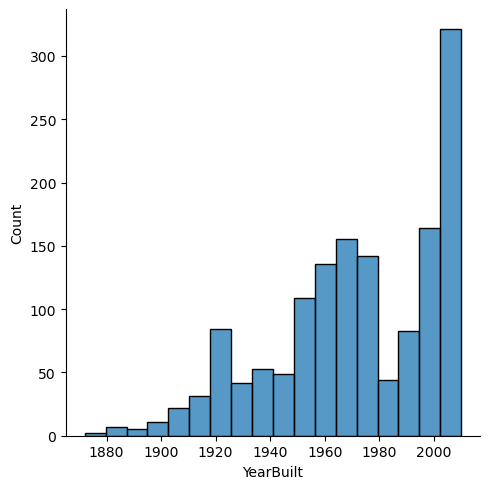

In [56]:
sns.displot(data['YearBuilt'])


Los datos parecen ser coherentes con la realidad, simplemente se les aplicará una conversión años de antigüedad para que el modelo entienda mejor este dato.

In [57]:
current_year = 2024
cleaned_data['Age'] = current_year - cleaned_data['YearBuilt']

cleaned_data = cleaned_data.drop('YearBuilt', axis=1)

## YearRemodAdd

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)


In [58]:
data["YearRemodAdd"].describe()

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

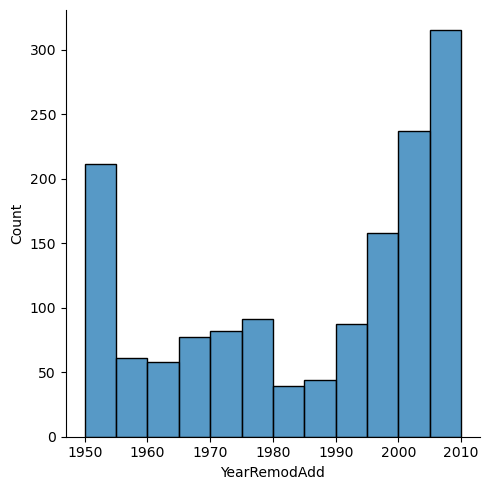

In [59]:
sns.displot(data['YearRemodAdd'])


El mismo tratamiento que YearBuilt.

In [60]:
current_year = 2024
cleaned_data['Ageremod'] = current_year - cleaned_data['YearRemodAdd']

cleaned_data = cleaned_data.drop('YearRemodAdd', axis=1)

## RoofStyle

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

In [61]:
data.groupby(["RoofStyle"])["RoofStyle"].count()

RoofStyle
Flat         13
Gable      1141
Gambrel      11
Hip         286
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

En esta variable se reagruparán las categorías en tres categorías más generales.

In [62]:
data['RoofStyle'] = data['RoofStyle'].replace({
    'Flat': 'Flat_Shed',
    'Shed': 'Flat_Shed',
    'Gable': 'Gable_Hip_Gambrel',
    'Hip': 'Gable_Hip_Gambrel',
    'Gambrel': 'Gable_Hip_Gambrel',
    'Mansard': 'Mansard'
})

roofstyle_encoded = pd.get_dummies(data['RoofStyle'], prefix='RoofStyle', drop_first=True)
data = data.drop('RoofStyle', axis=1)
data = pd.concat([data, roofstyle_encoded], axis=1)
cleaned_data = cleaned_data.drop(columns=['RoofStyle'])


## RoofMatl

RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

In [63]:
roofmatl_summary = data.groupby('RoofMatl').agg(
    Count=('RoofMatl', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

roofmatl_summary

,RoofMatl,Count,Mean_SalePrice
0,ClyTile,1,160000.000000
1,CompShg,1434,179803.679219
2,Membran,1,241500.000000
3,Metal,1,180000.000000
4,Roll,1,137000.000000
5,Tar&Grv,11,185406.363636
6,WdShake,5,241400.000000
7,WdShngl,6,390250.000000


En este caso se agruparán las categorías por precio medio de una forma similar a Neighborhood.

In [64]:
RoofMatl_price = cleaned_data.groupby('RoofMatl')['SalePrice'].mean()
RoofMatl_price

RoofMatl
CompShg    179803.679219
Membran    241500.000000
Metal      180000.000000
Roll       137000.000000
Tar&Grv    179747.000000
WdShake    241400.000000
WdShngl    390250.000000
Name: SalePrice, dtype: float64

In [65]:
RoofMatl_dict = {}
for RoofMatl, price in RoofMatl_price.items():
    if price < 129975:
        RoofMatl_dict[RoofMatl] = 'LowPrice'
    elif price < 214000:
        RoofMatl_dict[RoofMatl] = 'MildPrice'
    else:
        RoofMatl_dict[RoofMatl] = 'HighPrice'

In [66]:
RoofMatl_dict

{'CompShg': 'MildPrice',
 'Membran': 'HighPrice',
 'Metal': 'MildPrice',
 'Roll': 'MildPrice',
 'Tar&Grv': 'MildPrice',
 'WdShake': 'HighPrice',
 'WdShngl': 'HighPrice'}

In [67]:
cleaned_data['RoofMatl'] = cleaned_data['RoofMatl'].map(RoofMatl_dict)
cleaned_data.groupby('RoofMatl')['RoofMatl'].count()

RoofMatl
HighPrice      12
MildPrice    1446
Name: RoofMatl, dtype: int64

In [68]:
price_order = {'HighPrice': 2, 'MildPrice': 1, 'LowPrice': 0}
cleaned_data['RoofMatl'] = cleaned_data['RoofMatl'].map(price_order)

## Exterior1st y exterior2nd

Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [69]:
exterior1st_summary = data.groupby('Exterior1st').agg(
    Count=('Exterior1st', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

exterior1st_summary


,Exterior1st,Count,Mean_SalePrice
0,AsbShng,20,107385.550000
1,AsphShn,1,100000.000000
2,BrkComm,2,71000.000000
3,BrkFace,50,194573.000000
4,CBlock,1,105000.000000
5,CemntBd,61,231690.655738
6,HdBoard,222,163077.450450
7,ImStucc,1,262000.000000
8,MetalSd,220,149422.177273
9,Plywood,108,175942.379630


Se agruparán igualmente por precio medio, en esta ocasión se usará una función:

In [70]:
def map_price_categories(data, column_name):
    price_mean = data.groupby(column_name)['SalePrice'].mean()

    price_dict = {}
    for item, price in price_mean.items():
        if price < 129975:
            price_dict[item] = 'LowPrice'
        elif price < 214000:
            price_dict[item] = 'MildPrice'
        else:
            price_dict[item] = 'HighPrice'

    data[column_name] = data[column_name].map(price_dict)
    price_order = {'HighPrice': 2, 'MildPrice': 1, 'LowPrice': 0}
    data[column_name] = data[column_name].map(price_order)

    return data

cleaned_data = map_price_categories(cleaned_data, 'Exterior1st')
cleaned_data = map_price_categories(cleaned_data, 'Exterior2nd')


Finalmente fusionamos las dos columnas en una usando la media simple

In [71]:
cleaned_data['ExteriorCombined'] = cleaned_data[['Exterior1st', 'Exterior2nd']].mean(axis=1)
cleaned_data = cleaned_data.drop(columns=['Exterior1st', 'Exterior2nd'])


## MasVnrType

MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None 	None
       Stone	Stone

In [72]:
masvnrtype_summary = data.groupby('MasVnrType').agg(
    Count=('MasVnrType', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

masvnrtype_summary


,MasVnrType,Count,Mean_SalePrice
0,BrkCmn,15,146318.066667
1,BrkFace,445,204691.871910
2,None,864,156221.891204
3,Stone,128,265583.625000


En este caso se incluye BrkCmn que es ladrillo común en None. se incluye None en vez de BrkFace que es un ladrillo de revestimineto porque está más cerca de no ser un revestimiento con valor estético, como se puede ver en el precio medio. También se rellenan los valores nulos con None.

In [73]:
cleaned_data['MasVnrType'] = cleaned_data['MasVnrType'].fillna('None')
cleaned_data['MasVnrType'] = cleaned_data['MasVnrType'].replace({
    'None': 'BrkCmn',
})

mas_vnr_dummies = pd.get_dummies(cleaned_data['MasVnrType'], prefix='MasVnrType', drop_first=True)
cleaned_data = cleaned_data.drop('MasVnrType', axis=1)
cleaned_data = pd.concat([cleaned_data, mas_vnr_dummies], axis=1)


## MasVnrArea

MasVnrArea: Masonry veneer area in square feet


In [74]:
data["MasVnrArea"].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Simplemente se rellenan los valores nulos con 0

In [75]:
cleaned_data['MasVnrArea'].fillna(0, inplace=True)


## ExterQual

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Simplemente se le asignan valores numéricos

In [76]:
ExterQual_dict = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,
    'Po': 0
}

cleaned_data['ExterQual'] = cleaned_data['ExterQual'].map(ExterQual_dict)


## ExterCond

ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		

Exactamente igual que la anterior.

In [77]:
ExterCond_dict = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,
    'Po': 0
}

cleaned_data['ExterCond'] = cleaned_data['ExterCond'].map(ExterCond_dict)

## Foundation

Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

In [78]:
foundation_summary = data.groupby('Foundation').agg(
    Count=('Foundation', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

foundation_summary


,Foundation,Count,Mean_SalePrice
0,BrkTil,146,132291.075342
1,CBlock,634,149805.714511
2,PConc,647,225230.442040
3,Slab,24,107365.625000
4,Stone,6,165959.166667
5,Wood,3,185666.666667


Esta variable parece afectar signifcativamente al precio medio, así que no se reagrupan, simplemente se hace un onehot encoding.

In [79]:
foundation_encoded = pd.get_dummies(cleaned_data['Foundation'], prefix='Foundation', drop_first=True)
cleaned_data = cleaned_data.drop('Foundation', axis=1)
cleaned_data = pd.concat([cleaned_data, foundation_encoded], axis=1)


## BsmtQual

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

En esta caso se codificará la columna a valores numéricos, a mayores se creará una columna binaria que indique la presencia o no de sótano, ya que puede ser relevante para el modelo.

In [80]:
cleaned_data['BsmtQual'].fillna('NA', inplace=True)
bsmt_qual_mapping = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
}

cleaned_data['BsmtQual'] = cleaned_data['BsmtQual'].map(bsmt_qual_mapping)


In [81]:
cleaned_data['HasBasement'] = cleaned_data['BsmtQual'].apply(lambda x: 1 if x != 'NA' else 0)


## BsmtCond

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

Similar a la anterior.


In [82]:
cleaned_data['BsmtCond'].fillna('NA', inplace=True)
bsmt_cond_mapping = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
}

cleaned_data['BsmtCond'] = cleaned_data['BsmtCond'].map(bsmt_cond_mapping)


## BsmtExposure

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

In [83]:
cleaned_data['BsmtExposure'].fillna('NA', inplace=True)
cleaned_data['BsmtExposure'] = cleaned_data['BsmtExposure'].replace({
    'Gd': 4,
    'Av': 3,
    'Mn': 2,
    'No': 1,
    'NA': 0
})



In [84]:
cleaned_data

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofMatl,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,Ageremod,ExteriorCombined,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,HasBasement
0,65.0,9.042040,1,7,5,1,196.0,3,2,4,...,21,1.5,1,0,0,1,0,0,0,1
1,80.0,9.169623,2,6,8,1,0.0,2,2,4,...,48,1.0,0,0,1,0,0,0,0,1
2,68.0,9.328212,1,7,5,1,162.0,3,2,4,...,22,1.5,1,0,0,1,0,0,0,1
3,60.0,9.164401,1,7,5,1,0.0,2,2,3,...,54,1.0,0,0,0,0,0,0,0,1
4,84.0,9.565284,2,8,5,1,350.0,3,2,4,...,24,1.5,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,8.976894,1,6,5,1,0.0,2,2,4,...,24,1.5,0,0,0,1,0,0,0,1
1456,85.0,9.486152,1,6,6,1,119.0,2,2,4,...,36,1.0,0,1,1,0,0,0,0,1
1457,66.0,9.109746,1,7,9,1,0.0,4,3,3,...,18,2.0,0,0,0,0,0,1,0,1
1458,68.0,9.181735,1,5,6,1,0.0,2,2,3,...,28,1.0,0,0,1,0,0,0,0,1


BsmtFinSF2: Type 2 finished square feet


## BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF y TotalBsmtSF

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

1. BsmtFinType1 y BsmtFinSF1:
BsmtFinType1 describe el tipo de acabado principal en el sótano (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA).
BsmtFinSF1 representa los pies cuadrados acabados correspondientes al tipo principal de acabado del sótano descrito por BsmtFinType1.
Es decir, BsmtFinType1 indica la calidad del acabado en una parte del sótano, y BsmtFinSF1 cuantifica cuántos pies cuadrados corresponden a ese acabado.
2. BsmtFinType2 y BsmtFinSF2:
BsmtFinType2 describe el segundo tipo de acabado en el sótano (si hay más de un tipo de acabado).
BsmtFinSF2 indica los pies cuadrados acabados correspondientes a ese segundo tipo de acabado.
Si un sótano tiene áreas con diferentes tipos de acabado, BsmtFinType2 y BsmtFinSF2 complementan a BsmtFinType1 y BsmtFinSF1. Si no hay dos tipos de acabado, ambos pueden ser NA o 0.
3. BsmtUnfSF:
Representa los pies cuadrados no acabados del sótano. Es decir, esta variable indica qué parte del sótano no tiene ningún tipo de acabado.
4. TotalBsmtSF:
Esta variable representa el área total del sótano, y es la suma de todas las áreas, tanto las acabadas (BsmtFinSF1 + BsmtFinSF2) como las no acabadas (BsmtUnfSF).

Estas seis variables deberían poder resumirse en una sola, en primer lugar como hasta ahora le daremos un valor de 0 a los NA, luego le asignaremos valores ordinales a BsmtFintype 1 y 2, luego ponderaremos el valor de las áreas correspondientes, con una fórmula que será el valor normalizado de la correspondiente área con el valor de BsmtFintype para luego sumar todas las áreas.

In [85]:
cleaned_data['TotalBsmtSF_FinSF'] = (
    cleaned_data['BsmtFinSF1'] +
    cleaned_data['BsmtFinSF2'] +
    cleaned_data['BsmtUnfSF']
)

check_result = (cleaned_data['TotalBsmtSF'] == cleaned_data['TotalBsmtSF_FinSF'])
check_result.value_counts()

True    1458
dtype: int64

In [86]:
cleaned_data['BsmtFinType1'].fillna('NA', inplace=True)
cleaned_data['BsmtFinType2'].fillna('NA', inplace=True)



cleaned_data['BsmtFinType1'] = cleaned_data['BsmtFinType1'].replace({
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    'NA': 0
})

cleaned_data['BsmtFinType2'] = cleaned_data['BsmtFinType2'].replace({
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    'NA': 0
})

max_area = cleaned_data['TotalBsmtSF'].max()
cleaned_data['BsmtFinSF1'] = cleaned_data['BsmtFinSF1'] / max_area
cleaned_data['BsmtFinSF2'] = cleaned_data['BsmtFinSF2'] / max_area
cleaned_data['BsmtUnfSF'] = cleaned_data['BsmtUnfSF'] / max_area

cleaned_data['BsmtQualityScore'] = (
    (cleaned_data['BsmtFinType1'] * cleaned_data['BsmtFinSF1']) + 
    (cleaned_data['BsmtFinType2'] * cleaned_data['BsmtFinSF2']) + 
    cleaned_data['BsmtUnfSF']
)

cleaned_data = cleaned_data.drop(columns=['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'TotalBsmtSF_FinSF'])

cleaned_data['BsmtQualityScore']


0       1.368060
1       1.613849
2       1.044916
3       0.505303
4       1.378665
          ...   
1455    0.297255
1456    1.568309
1457    0.788210
1458    1.054585
1459    1.258890
Name: BsmtQualityScore, Length: 1458, dtype: float64

## Heating

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

In [87]:
heating_summary = data.groupby('Heating').agg(
    Count=('Heating', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

heating_summary


,Heating,Count,Mean_SalePrice
0,Floor,1,72500.000000
1,GasA,1428,182021.195378
2,GasW,18,166632.166667
3,Grav,7,75271.428571
4,OthW,2,125750.000000
5,Wall,4,92100.000000


Vemos que en la variable Heating hay preponderancia de la categoría GasA que además es la que tiene mayor precio medio, con lo cual convertiremos Heating en una variable binaria de GASA

In [88]:
cleaned_data['Heating_GasA'] = cleaned_data['Heating'].apply(lambda x: 1 if x == 'GasA' else 0)
cleaned_data = cleaned_data.drop(columns=['Heating'])


## HeatingQC

HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [89]:
cleaned_data['HeatingQC'] = cleaned_data['HeatingQC'].replace({
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1
})

## CentralAir

CentralAir: Central air conditioning

       N	No
       Y	Yes
		

In [90]:
cleaned_data['CentralAir'] = cleaned_data['CentralAir'].replace({
    'Y': 1,
    'N': 0
})


## Electrical

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [91]:
electrical_summary = data.groupby('Electrical').agg(
    Count=('Electrical', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

electrical_summary


,Electrical,Count,Mean_SalePrice
0,FuseA,94,122196.893617
1,FuseF,27,107675.444444
2,FuseP,3,97333.333333
3,Mix,1,67000.000000
4,SBrkr,1334,186825.113193


Es un caso parecido a Heating destacando SBkr tanto en frecuencia como en precio medio, por lo que se actúa de idéntica manera.

In [92]:
cleaned_data['Electrical_SBrkr'] = cleaned_data['Electrical'].apply(lambda x: 1 if x == 'SBrkr' else 0)
cleaned_data = cleaned_data.drop(columns=['Electrical'])


## 1stFlrSF

1stFlrSF: First Floor square feet


In [93]:
data['1stFlrSF'].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

Esta variable se deja como está, su valor máximo es alto (unos 400 metros cuadrados), pero no absurdo.

## 2ndFlrSF

2ndFlrSF: Second floor square feet


In [94]:
data['2ndFlrSF'].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

Tambien se deja como está.

## LowQualFinSF

Low quality finished square feet (all floors)


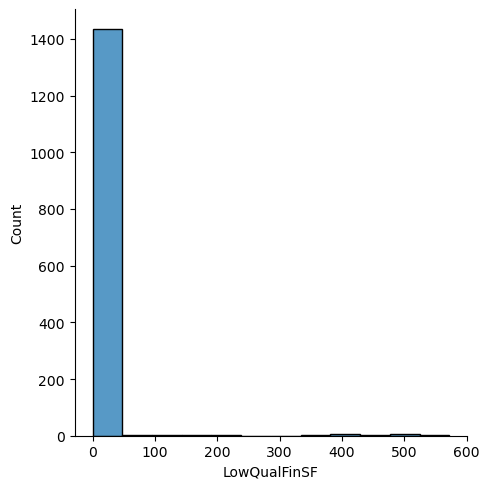

In [95]:
sns.displot(data['LowQualFinSF'])

In [96]:
greater_than_zero_count = (cleaned_data['LowQualFinSF'] > 0).sum()
print("Número de valores de LowQualFinSF mayores que 0:", greater_than_zero_count)


Número de valores de LowQualFinSF mayores que 0: 26


El número de valores mayores que 0 es demasiado bajo como para que esta variable sea digna de tenida en cuenta.

In [97]:
cleaned_data.drop(columns=['LowQualFinSF'], inplace=True)


## GrLivArea

GrLivArea: Above grade (ground) living area square feet

In [98]:
data["GrLivArea"].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Esta variable se deja intacta.

## BsmtFullBath y BsmtHalfBath

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

Estas dos variables se fusionan fácilmente multiplicando el número de mediobaños por 0.5 y sumándolas.

In [99]:
cleaned_data['TotalBasementBaths'] = (
    cleaned_data['BsmtFullBath'] + (cleaned_data['BsmtHalfBath'] * 0.5)
)
cleaned_data = cleaned_data.drop(columns=['BsmtFullBath', 'BsmtHalfBath'])


## FullBath y HalfBath

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

In [100]:
cleaned_data['TotalBaths'] = (
    cleaned_data['FullBath'] + (cleaned_data['HalfBath'] * 0.5)
)
cleaned_data = cleaned_data.drop(columns=['FullBath', 'HalfBath'])

Se hace lo mismo que en la anterior variable.

## Bedroom

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)


Se deja intaca

## Kitchen


Kitchen : Kitchens above grade

Tampoco se le hace ninguna transformación,

## KitchenQual

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

Se sustituyen los valores categóricos por ordinales.

In [101]:
cleaned_data['KitchenQual'] = cleaned_data['KitchenQual'].replace({
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1
})


## TotRmsAbvGrd

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)


In [102]:
cleaned_data['Total_Kitchen_Bedroom'] = cleaned_data['KitchenAbvGr'] + cleaned_data['BedroomAbvGr']
check_totrms = (cleaned_data['TotRmsAbvGrd'] == cleaned_data['Total_Kitchen_Bedroom'])
check_totrms.value_counts()
cleaned_data.drop(columns=['Total_Kitchen_Bedroom'], inplace=True)

TotRmsAbvGrd parece incluir más habitaciones a parte de cocinas y dormitorios, dado que aporta información nueva, se mantiene.

## Functional

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only


Se codifica de forma ordinaria. Ya que la naturaleza de las categorías lo permite.


In [103]:
cleaned_data['Functional'] = cleaned_data['Functional'].replace({
    'Typ': 7,
    'Min1': 6,
    'Min2': 5,
    'Mod': 4,
    'Maj1': 3,
    'Maj2': 2,
    'Sev': 1,
    'Sal': 0
})


## Fireplaces

Fireplaces: Number of fireplaces

Se deja como está.

## FireplaceQu


FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Se codifica de forma ordinal. Ya que la naturaleza de las categorías lo permite.

In [104]:
cleaned_data['FireplaceQu'].fillna('NA', inplace=True)
cleaned_data['FireplaceQu'] = cleaned_data['FireplaceQu'].replace({
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
})


## GarageType

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

In [105]:
garage_type_summary = data.groupby('GarageType').agg(
    Count=('GarageType', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

garage_type_summary


,GarageType,Count,Mean_SalePrice
0,2Types,6,151283.333333
1,Attchd,870,202892.656322
2,Basment,19,160570.684211
3,BuiltIn,88,254751.738636
4,CarPort,9,109962.111111
5,Detchd,387,134091.162791


Esta categoría se reagrupará en función de si están unidos a la casa (más caro) o no.



In [106]:
cleaned_data['GarageType'] = cleaned_data['GarageType'].fillna('No Garage')

cleaned_data['GarageType_Reduced'] = cleaned_data['GarageType'].replace({
    'Attchd': 'Attached', 
    'BuiltIn': 'Attached', 
    'Detchd': 'Detached', 
    'Basment': 'Detached', 
    'CarPort': 'Detached', 
    '2Types': 'Other',
    'No Garage': 'No Garage'
})

garage_dummies = pd.get_dummies(cleaned_data['GarageType_Reduced'], prefix='GarageType')

cleaned_data = pd.concat([cleaned_data, garage_dummies], axis=1)
cleaned_data = cleaned_data.drop(columns=['GarageType', 'GarageType_Reduced'])


In [107]:
cleaned_data

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofMatl,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,HasBasement,BsmtQualityScore,Heating_GasA,Electrical_SBrkr,TotalBasementBaths,TotalBaths,GarageType_Attached,GarageType_Detached,GarageType_No Garage,GarageType_Other
0,65.0,9.042040,1,7,5,1,196.0,3,2,4,...,1,1.368060,1,1,1.0,2.5,1,0,0,0
1,80.0,9.169623,2,6,8,1,0.0,2,2,4,...,1,1.613849,1,1,0.5,2.0,1,0,0,0
2,68.0,9.328212,1,7,5,1,162.0,3,2,4,...,1,1.044916,1,1,1.0,2.5,1,0,0,0
3,60.0,9.164401,1,7,5,1,0.0,2,2,3,...,1,0.505303,1,1,1.0,1.0,0,1,0,0
4,84.0,9.565284,2,8,5,1,350.0,3,2,4,...,1,1.378665,1,1,1.0,2.5,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,8.976894,1,6,5,1,0.0,2,2,4,...,1,0.297255,1,1,0.0,2.5,1,0,0,0
1456,85.0,9.486152,1,6,6,1,119.0,2,2,4,...,1,1.568309,1,1,1.0,2.0,1,0,0,0
1457,66.0,9.109746,1,7,9,1,0.0,4,3,3,...,1,0.788210,1,1,0.0,2.0,1,0,0,0
1458,68.0,9.181735,1,5,6,1,0.0,2,2,3,...,1,1.054585,1,0,1.0,1.0,1,0,0,0


## GarageYrBlt

GarageYrBlt: Year garage was built


In [108]:
data["GarageYrBlt"].describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

Se pasa a años de antigüedad como otras variables.


























In [109]:
cleaned_data['GarageAge'] = 2024 - cleaned_data['GarageYrBlt']
cleaned_data['GarageAge'] = cleaned_data['GarageAge'].fillna(0)
cleaned_data = cleaned_data.drop(columns=['GarageYrBlt'])



## GarageFinish

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [110]:
cleaned_data['GarageFinish'].fillna('NA', inplace=True)
cleaned_data['GarageFinish'] = cleaned_data['GarageFinish'].replace({
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
    'NA': 0
})

## GarageCars 

GarageCars: Size of garage in car capacity


Se deja como está.

## GarageArea

GarageArea: Size of garage in square feet


In [111]:
data["GarageArea"].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

El máximo es elevado pero entra dentro de lo que podría medir el área de un garage muy grande.

## GarageQual

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

Se codifica ordinalmente.

In [112]:
cleaned_data['GarageQual'].fillna('NA', inplace=True)
cleaned_data['GarageQual'] = cleaned_data['GarageQual'].replace({
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
})


## GarageCond

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

Se codifica ordinalmente.

In [113]:
cleaned_data['GarageCond'].fillna('NA', inplace=True)
cleaned_data['GarageCond'] = cleaned_data['GarageCond'].replace({
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
})


## PavedDrive

PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		

paveddrive_summary = data.groupby('PavedDrive').agg(
    Count=('PavedDrive', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

paveddrive_summary


In [114]:
paveddrive_dummies = pd.get_dummies(cleaned_data['PavedDrive'], prefix='PavedDrive')
cleaned_data = pd.concat([cleaned_data, paveddrive_dummies], axis=1)
cleaned_data = cleaned_data.drop(columns=['PavedDrive'])


Se codifica usando get_dummies

## WoodDeckSF

WoodDeckSF: Wood deck area in square feet


In [115]:
data["WoodDeckSF"].describe()

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

Se deja como está.

## OpenPorchSF, EnclosedPorch, 3SsnPorch y  ScreenPorch

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet


In [116]:
non_zero_counts = {
    'OpenPorchSF': (cleaned_data['OpenPorchSF'] != 0).sum(),
    'EnclosedPorch': (cleaned_data['EnclosedPorch'] != 0).sum(),
    '3SsnPorch': (cleaned_data['3SsnPorch'] != 0).sum(),
    'ScreenPorch': (cleaned_data['ScreenPorch'] != 0).sum()
}

non_zero_counts


{'OpenPorchSF': 803, 'EnclosedPorch': 208, '3SsnPorch': 24, 'ScreenPorch': 116}

Los valores distintos de 0 tienen un frecuencia muy baja en la mayoría de estas variables, haciendo aconsejable unirlas en una sola.

In [117]:
cleaned_data['TotalPorchSF'] = (
    cleaned_data['OpenPorchSF'] + 
    cleaned_data['EnclosedPorch'] + 
    cleaned_data['3SsnPorch'] + 
    cleaned_data['ScreenPorch']
)

cleaned_data = cleaned_data.drop(columns=['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'])


## PoolArea

PoolArea: Pool area in square feet


In [118]:
data["PoolArea"].describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

El máximo es algo más grande que una piscina olímpica pero podría ser posible una piscina de ese tamaño.

## PoolQC

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [119]:
data['PoolQC'].isna().sum()

1453

Hay demasiados valores nulos como para que compense mantener esta variable.

In [120]:
cleaned_data = cleaned_data.drop(columns=['PoolQC'])


## Fence

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [121]:
data['Fence'].isna().sum()

1179

In [122]:
cleaned_data = cleaned_data.drop(columns=['Fence'])


## MiscFeature

MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

Esta variable se elimina ya que MiscVal, nos dice exactamente cual es el impacto en el precio de estas características y además es mayaría de nulos.

In [123]:
cleaned_data = cleaned_data.drop(columns=['MiscFeature'])


## MiscVal


MiscVal: $Value of miscellaneous feature


In [124]:
data["MiscVal"].describe()

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

Se deja como está.

## MoSold

MoSold: Month Sold (MM)


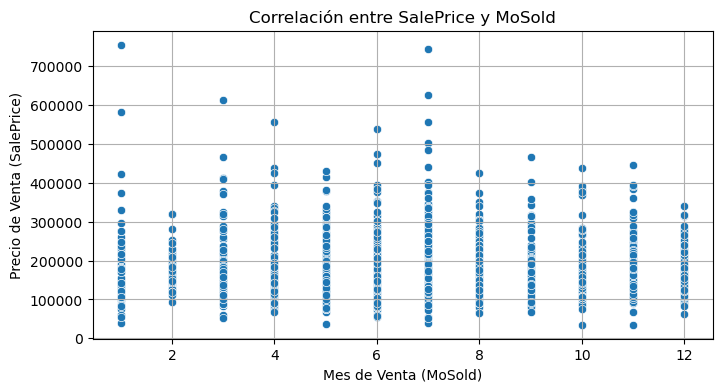

Correlación entre SalePrice y MoSold: 0.045282134827988485


In [125]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=cleaned_data, x='MoSold', y='SalePrice')
plt.title('Correlación entre SalePrice y MoSold')
plt.xlabel('Mes de Venta (MoSold)')
plt.ylabel('Precio de Venta (SalePrice)')
plt.grid()
plt.show()
correlation = cleaned_data['SalePrice'].corr(cleaned_data['MoSold'])
print(f'Correlación entre SalePrice y MoSold: {correlation}')

Como ya se podía intuir el mes no parece influir en el precio de venta, así que lo eliminamos.

In [126]:
cleaned_data = cleaned_data.drop(columns=['MoSold'])


 ## YrSold

YrSold: Year Sold (YYYY)


Se pasa años de antigüedad

In [127]:
cleaned_data['AgeSold'] = 2024 - cleaned_data['YrSold']
cleaned_data = cleaned_data.drop(columns=['YrSold'])


## SaleType

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		

In [128]:
sale_type_summary = cleaned_data.groupby('SaleType').agg(
    Count=('SaleType', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

sale_type_summary


,SaleType,Count,Mean_SalePrice
0,COD,43,143973.255814
1,CWD,4,210600.000000
2,Con,2,269600.000000
3,ConLD,9,138780.888889
4,ConLI,5,200390.000000
5,ConLw,5,143700.000000
6,New,121,275895.380165
7,Oth,3,119850.000000
8,WD,1266,173347.651659


Se hace codificación onehot.

In [129]:
sale_type_dummies = pd.get_dummies(cleaned_data['SaleType'], prefix='SaleType')
cleaned_data = pd.concat([cleaned_data, sale_type_dummies], axis=1)
cleaned_data = cleaned_data.drop(columns=['SaleType'])


## SaleCondition

SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

In [130]:
salecondition_summary = data.groupby('SaleCondition').agg(
    Count=('SaleCondition', 'count'),
    Mean_SalePrice=('SalePrice', 'mean')
).reset_index()

salecondition_summary


,SaleCondition,Count,Mean_SalePrice
0,Abnorml,101,146526.623762
1,AdjLand,4,104125.000000
2,Alloca,12,167377.416667
3,Family,20,149600.000000
4,Normal,1198,175202.219533
5,Partial,125,272291.752000


In [131]:
sale_type_dummies = pd.get_dummies(cleaned_data['SaleCondition'], prefix='Salecondition')
cleaned_data = pd.concat([cleaned_data, sale_type_dummies], axis=1)
cleaned_data = cleaned_data.drop(columns=['SaleCondition'])

Se hace onehot conservando todas las variables.

In [132]:
cleaned_data

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofMatl,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Salecondition_Abnorml,Salecondition_AdjLand,Salecondition_Alloca,Salecondition_Family,Salecondition_Normal,Salecondition_Partial
0,65.0,9.042040,1,7,5,1,196.0,3,2,4,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9.169623,2,6,8,1,0.0,2,2,4,...,0,0,0,1,0,0,0,0,1,0
2,68.0,9.328212,1,7,5,1,162.0,3,2,4,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9.164401,1,7,5,1,0.0,2,2,3,...,0,0,0,1,1,0,0,0,0,0
4,84.0,9.565284,2,8,5,1,350.0,3,2,4,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,8.976894,1,6,5,1,0.0,2,2,4,...,0,0,0,1,0,0,0,0,1,0
1456,85.0,9.486152,1,6,6,1,119.0,2,2,4,...,0,0,0,1,0,0,0,0,1,0
1457,66.0,9.109746,1,7,9,1,0.0,4,3,3,...,0,0,0,1,0,0,0,0,1,0
1458,68.0,9.181735,1,5,6,1,0.0,2,2,3,...,0,0,0,1,0,0,0,0,1,0


In [133]:
summary = [
    [col, cleaned_data[col].dtype, cleaned_data[col].count(), cleaned_data[col].nunique(), cleaned_data[col].isnull().sum(), cleaned_data.duplicated().sum()]
    for col in cleaned_data.columns
]

df_check = pd.DataFrame(summary, columns=['column', 'dtype', 'instances', 'unique', 'missing_vals', 'duplicates'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

df_check


,column,dtype,instances,unique,missing_vals,duplicates
0,LotFrontage,float64,1458,110,0,0
1,LotArea,float64,1458,1071,0,0
2,Neighborhood,int64,1458,3,0,0
3,OverallQual,int64,1458,10,0,0
4,OverallCond,int64,1458,9,0,0
5,RoofMatl,int64,1458,2,0,0
6,MasVnrArea,float64,1458,326,0,0
7,ExterQual,int64,1458,4,0,0
8,ExterCond,int64,1458,5,0,0
9,BsmtQual,int64,1458,5,0,0


Ahora que todas las variables están en formato numérico analizamos la correlación entre ellas. Concretamente vamos a ver si hay variables con una correlación positiva o negativa demasiado elevada.

In [134]:
corr_matrix = cleaned_data.corr()

high_corr_vars = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Correlation'])

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_vars = high_corr_vars.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            }, ignore_index=True)

print(high_corr_vars)

              Variable 1           Variable 2  Correlation
0           TotRmsAbvGrd            GrLivArea        0.828
1            FireplaceQu           Fireplaces        0.865
2             GarageArea           GarageCars        0.888
3             GarageCond           GarageQual        0.959
4            MSZoning_RM          MSZoning_RL       -0.809
5    GarageType_Detached  GarageType_Attached       -0.870
6   GarageType_No Garage           GarageQual       -0.942
7   GarageType_No Garage           GarageCond       -0.946
8           PavedDrive_Y         PavedDrive_N       -0.856
9  Salecondition_Partial         SaleType_New        0.987


C:\Users\oscar\AppData\Local\Temp\ipykernel_78256\3948841595.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_vars = high_corr_vars.append({
C:\Users\oscar\AppData\Local\Temp\ipykernel_78256\3948841595.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_vars = high_corr_vars.append({
C:\Users\oscar\AppData\Local\Temp\ipykernel_78256\3948841595.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_vars = high_corr_vars.append({
C:\Users\oscar\AppData\Local\Temp\ipykernel_78256\3948841595.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_vars = high_corr_vars.append({
C:\Users\oscar\AppData\Local

## TotRmsAbvGrd vs. GrLivArea (0.828)       

Muestran una correlación elevada, es lógico que a mayor número de habitaciomes mayor área habitable, sin embargo la información que aportan no es redundante, así que se mantienen las dos.

## FireplaceQu vs. Fireplaces (0.865)

Parece que la variable FireplaceQu ya tiene en cuenta el número de chimeneas, en cualquier caso con mantener una parece suficiente. 

In [135]:
cleaned_data = cleaned_data.drop(columns=['Fireplaces'])


## GarageArea vs. GarageCars (0.888)

A mayor número de coches mayor área, no hay motivo para mantener las dos.

In [136]:
cleaned_data = cleaned_data.drop(columns=['GarageCars'])


## GarageCond vs. GarageQual (0.959)

La correlación es áltisima, con mantener una es suficiente.

In [137]:
cleaned_data = cleaned_data.drop(columns=['GarageCond'])


## MSZoning_RM vs. MSZoning_RL (-0.809)

Es lógico que estas zonas se excluyan mutuamente.

In [138]:
cleaned_data = cleaned_data.drop(columns=['MSZoning_RM'])


## GarageType_Detached vs. GarageType_Attached (-0.870)

Similar al caso anterior, estos tipos de garaje son mutuamente excluyentes.


In [139]:
cleaned_data = cleaned_data.drop(columns=['GarageType_Attached'])


## GarageType_No Garage vs. GarageQual (-0.942) y GarageCond (-0.946)

Parece que la GarageQual ya contempla el hecho de que no haya garage ortogándole una calidad muy baja a esa propiedad.

In [140]:
cleaned_data = cleaned_data.drop(columns=['GarageType_No Garage'])


## PavedDrive_Y vs. PavedDrive_N (-0.856):

Mutuamente excluyentes 

In [141]:
cleaned_data = cleaned_data.drop(columns=['PavedDrive_N'])


## Salecondition_Partial vs. SaleType_New (0.987)

Son prácticamente iguales.

In [142]:
cleaned_data = cleaned_data.drop(columns=['Salecondition_Partial'])


In [143]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LotFrontage                     1458 non-null   float64
 1   LotArea                         1458 non-null   float64
 2   Neighborhood                    1458 non-null   int64  
 3   OverallQual                     1458 non-null   int64  
 4   OverallCond                     1458 non-null   int64  
 5   RoofMatl                        1458 non-null   int64  
 6   MasVnrArea                      1458 non-null   float64
 7   ExterQual                       1458 non-null   int64  
 8   ExterCond                       1458 non-null   int64  
 9   BsmtQual                        1458 non-null   int64  
 10  BsmtCond                        1458 non-null   int64  
 11  BsmtExposure                    1458 non-null   int64  
 12  HeatingQC                       14

In [144]:
#Ruta para guardar el archivo CSV
csv_path = "Data/train_2.csv"

# Guardar el DataFrame como un archivo CSV
cleaned_data.to_csv(csv_path, index=False)#

print(f"El dataset se ha guardado en {csv_path}")

El dataset se ha guardado en Data/train_2.csv
